<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/7_arima_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load DataFrames called `electricity`, `dowjones` and `white`

In [3]:
! pip install --upgrade statsmodels

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from statsmodels.tsa.stattools import adfuller


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/aus_electricity.csv > aus_electricity.csv
!curl https://vcu-scma-440.s3.amazonaws.com/data/dowjones.csv > dowjones.csv
!curl https://vcu-scma-440.s3.amazonaws.com/data/pigs.csv > pigs.csv

dowjones = pd.read_csv('dowjones.csv', parse_dates=['date']).set_index('date')
elec = pd.read_csv('aus_electricity.csv', parse_dates=['date']).set_index('date')
pigs = pd.read_csv('pigs.csv', parse_dates=['date']).set_index('date')

import numpy as np
np.random.seed = 42

white = pd.DataFrame(index=elec.index)
white['white'] = np.random.randn(white.shape[0]) + 23

random_walk = pd.DataFrame(index=elec.index)

val = 23
rw = [val]
for i in range(random_walk.shape[0]-1):
    val += np.random.randn(1)[0]
    rw.append(val)
    
random_walk['walk'] = rw

elec = elec.tail(100)

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7777  100  7777    0     0  74778      0 --:--:-- --:--:-- --:--:-- 74778
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5270  100  5270    0     0  71216      0 --:--:-- --:--:-- --:--:-- 72191
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1257  100  1257    0     0  16324      0 --:--:-- --:--:-- --:--:-- 16324


# Exploring the Data

First, let's take a look at our data sets. We first can plot the `white` and `random_walk`, which are our theoretical points of comparison. 

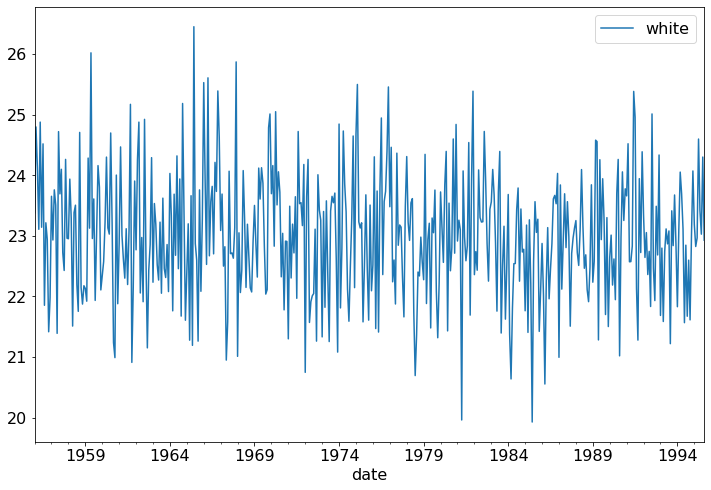

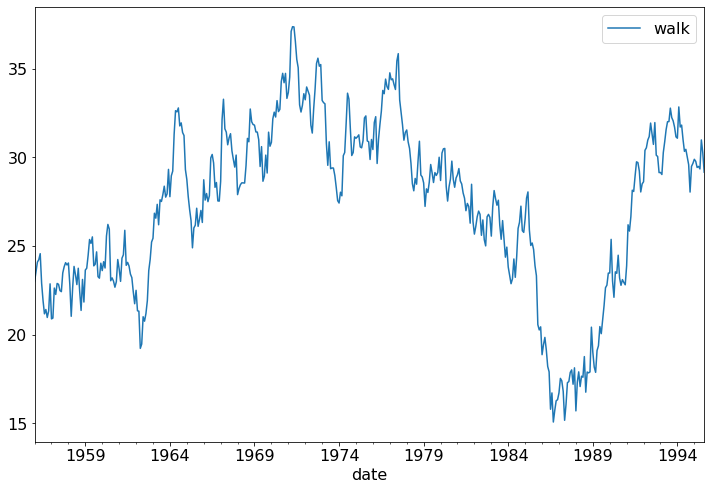

In [4]:
display(white.plot())
display(random_walk.plot())

We can then take a look at the three real time series that we'll work with, `elec` which is monthly electricity production in Australia, `dowjones` which is the daily DJI for just under one year, and `pigs` which represents the monthly total number of pigs slaughtered in Australia in the early 1990's

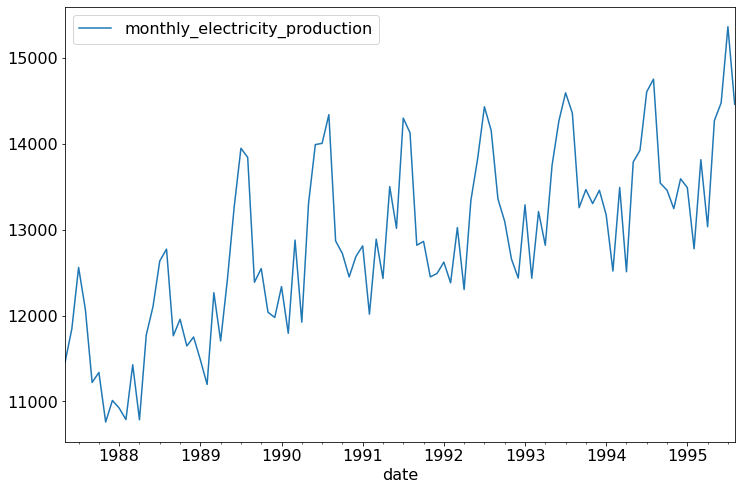

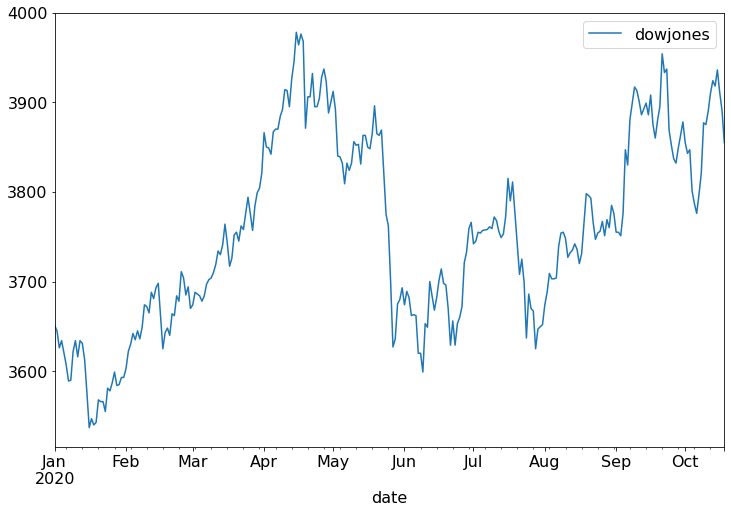

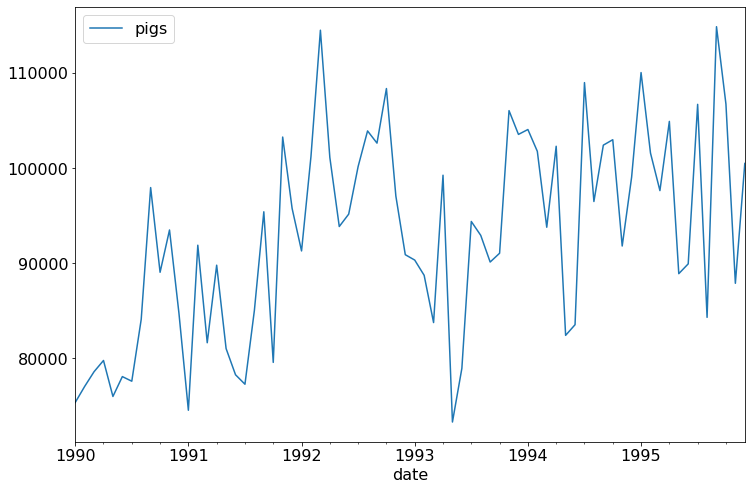

In [5]:
display(elec.plot())
display(dowjones.plot())
display(pigs.plot())

# Examining Autocorrelations
Let's begin by analyzing the above series for autocorrelations. We'll do so by:

* Computing the ACF and PACF
* Portmandeau Tests

To plot the ACF and PACF, we can use the functions `plot_acf` and `plot_pacf` from `statsmodels.graphics.tsaplots`. To import, we call:

```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
```

Let's start by taking a look at the ACF of the `dowjones` `DataFrame`. To plot the ACF and PACF, we simply pass in the column that we're interested in, e.g.:

```python
my_figure = plot_acf(my_data['my_column'], zero=False)
```

We add in the `zero=False` argument to prevent the ACF from plotting the self correlation term which is always 1

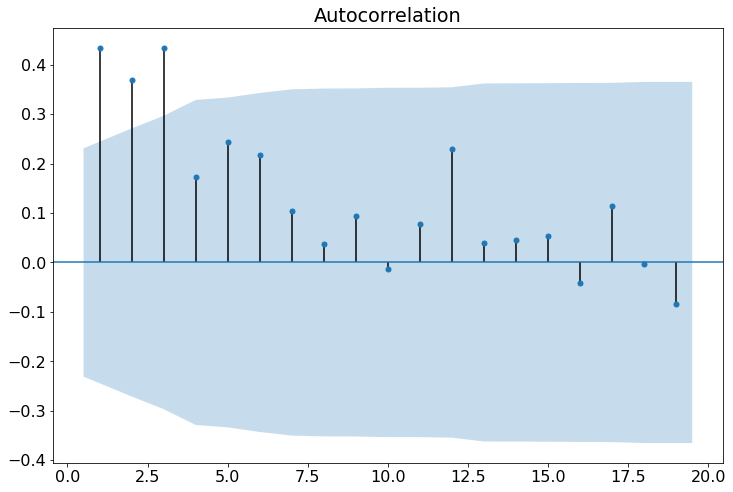

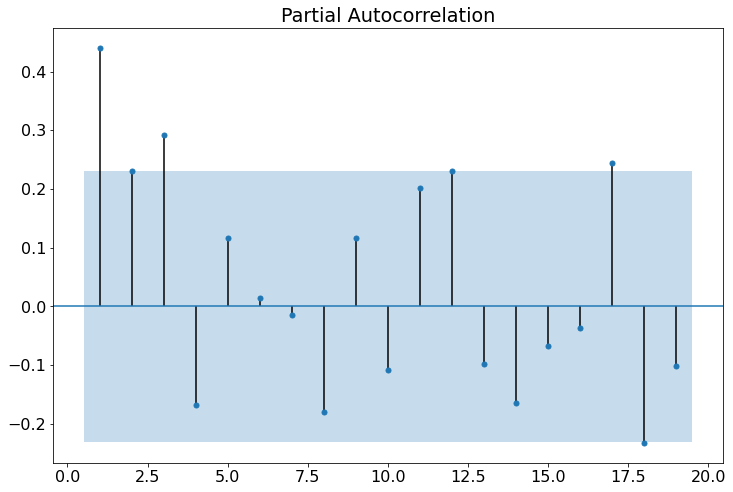

In [6]:
my_acf = plot_acf(pigs['pigs'], zero=False)
my_pacf = plot_pacf(pigs['pigs'], zero=False)

Here, we observe a strong autocorrelation at lags 1, 2, and 3, and a fairly large partial autocorrelation at 12 (yearly). 

As a useful comparison, we can compute the same for our white noise model:

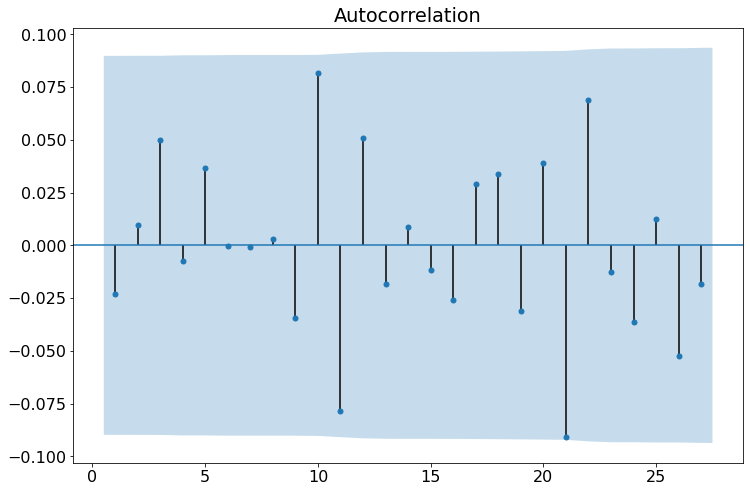

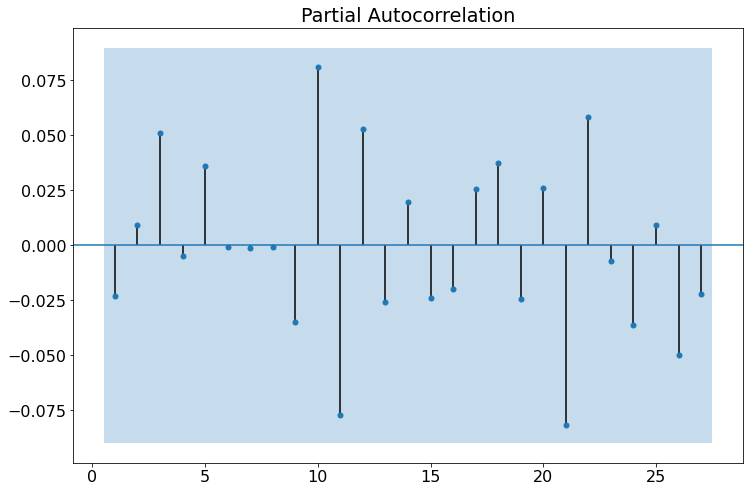

In [7]:
my_acf = plot_acf(white['white'], zero=False)
my_pacf = plot_pacf(white['white'], zero=False)


To further establish the presence of autocorrelation in this series, we can use the function `acorr_ljungbox`, which can be imported from `statsmodels.stats.diagnostic` as follows:

```python
from statsmodels.stats.diagnostic import acorr_ljungbox
```

Recall that the Ljung-Box $Q^*$ statistic is computed for a set of lags up to a given lag `h`:

$$ Q^* = n(n+2) \sum_{n-k}^{h}(n-k)^{-1}r^2_k $$

To compute the Ljung-Box statistic for a given value of `h` (usually chosen to be 10, 20, or somewhere in between), you call:

```python
results_df = acorr_ljungbox(my_data['my_column'], lags=[10], return_df=True)
```

Here, we additionally specify that we want the function to return a `DataFrame` so that the results are easier to read

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox
jb_results = acorr_ljungbox(pigs['pigs'], lags=[20], return_df=True)
jb_results

,lb_stat,lb_pvalue
20,59.682341,0.000008


Notice here that the value of the Ljung-Box statistic is very large, and the p-value is very small, which strongly indicates the presence of autocorrelation. 

# Exploring Stationarity
Now let's turn our attention to stationarity of the data. Let's start by considering the `dowjones` `DataFrame`. From the plot above, this data is clearly non-stationary. Let's start by taking a look at the ACF and PACF:

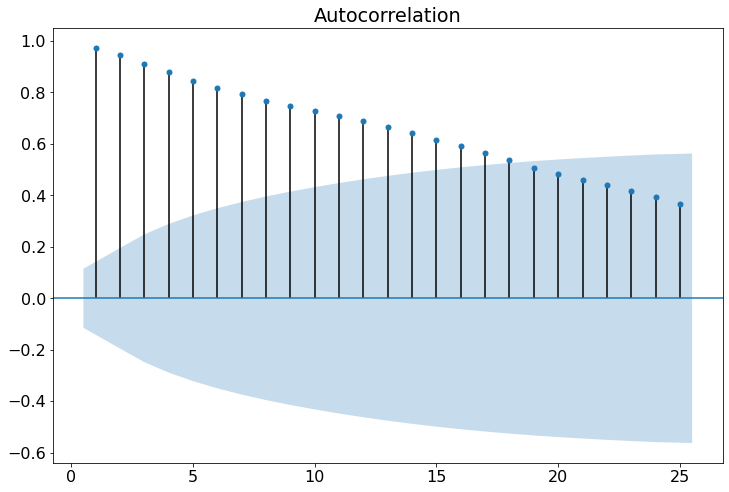

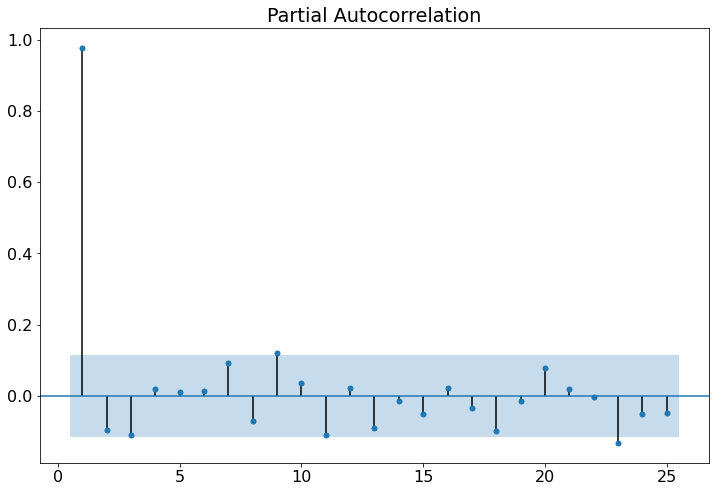

In [11]:
my_acf = plot_acf(dowjones['dowjones'], zero=False)
my_pcf = plot_pacf(dowjones['dowjones'], zero=False)

The slow decrease in autocorrelations and spike at lag 1 for the PACF are indicative of non-stationarity. Let's now try differencing the data and again plotting the ACF and PACF:

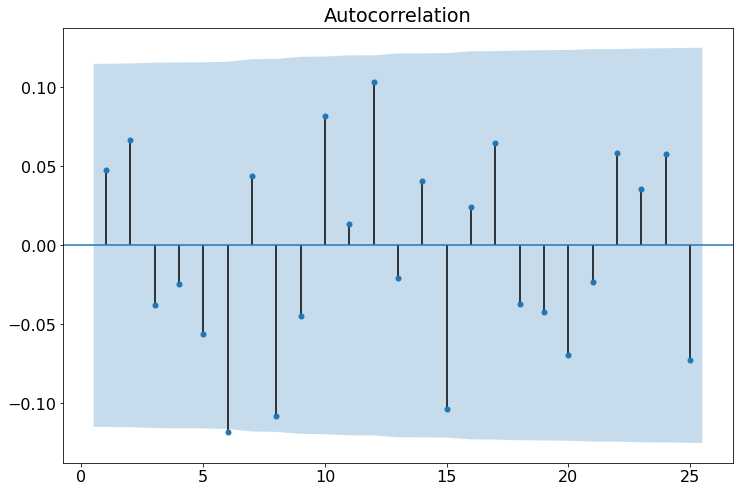

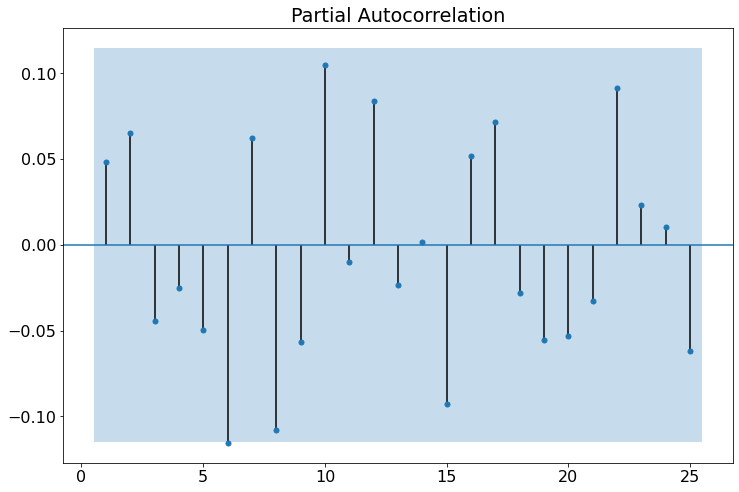

In [27]:
dowjones['diff1'] = dowjones['dowjones'].diff(1)
dowjones = dowjones.dropna()

my_acf = plot_acf(dowjones['diff1'], zero=False)
my_pacf = plot_pacf(dowjones['diff1'], zero=False)

Notice now that the above series looks much more stationary, and exhibits no significant autocorrelation. If we further want to estimate the presence of non-stationarity, we can use the Dickey-Fuller test. We can import the `adfuller` function from `statsmodels.tsa.stattools` as follows:

```
from statsmodels.tsa.stattools import adfuller
```

We can carry out a Dickey-Fuller test as follows:

```
results = adfuller(my_data['my_column'])
```

the p-value is returned as the second argument of `results`, so we can inspect it with:

```
print(results[1])
```

In [37]:
results = adfuller(dowjones['dowjones'])
print('original series p-value: ',results[1])

results = adfuller(dowjones['diff1'])
print('diff1 series p-value: ',results[1])

original series p-value:  0.3550441797099476
diff1 series p-value:  5.187907879212891e-29


Recall that a significant result for the Dickey-Fuller test indicates stationarity, so it appears that we have effectively used differencing to make our series stationary